In [2]:

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
neighborhoods_path = "/Users/lijunyi/Downloads/Census2020_BG_Neighborhoods/Census2020_BG_Neighborhoods.shp"
bus_routes_path = "/Users/lijunyi/Downloads/cs506/Bus_Network_Redesign_Draft_Bus_Routes/Bus_Network_Redesign_Draft_Bus_Routes.shp"
neighborhood_data_path = "/Users/lijunyi/Downloads/Boston_Neighborhood_Boundaries_approximated_by_2020_Census_Block_Groups.csv"
coordinates_map = pd.read_csv('/Users/lijunyi/Downloads/coordinates_map.txt', sep="\t", header=None, names=["Longitude", "Latitude"])

neighborhoods = gpd.read_file(neighborhoods_path)
bus_routes = gpd.read_file(bus_routes_path)
neighborhood_data = pd.read_csv(neighborhood_data_path)




/Users/lijunyi/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/lijunyi/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


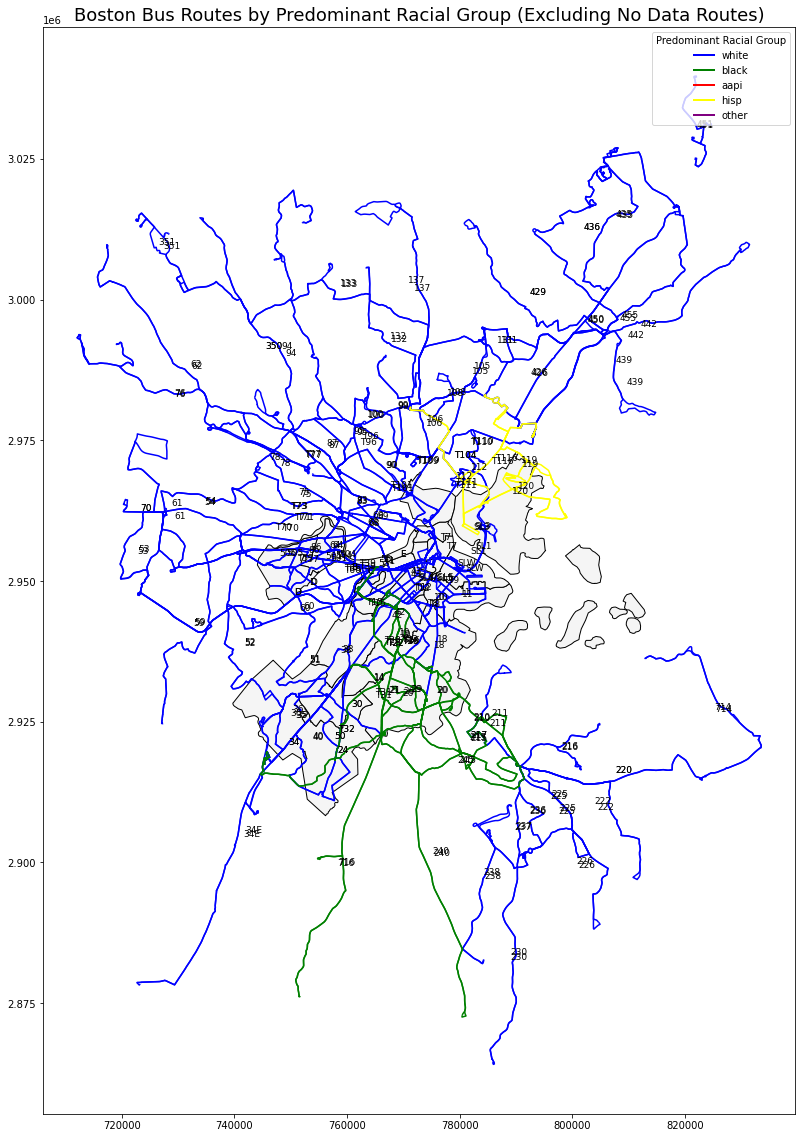

In [3]:
# Convert the CRS of bus_routes to match that of neighborhoods
bus_routes = bus_routes.to_crs(neighborhoods.crs)

# Determine intersecting neighborhoods
bus_routes['neighborhoods'] = bus_routes['geometry'].apply(lambda route: neighborhoods[neighborhoods.geometry.intersects(route)]['BlockGr202'].tolist())

# Extract relevant columns from neighborhood_data for merging and merge
relevant_cols = ['blockgr2020_ctr_neighb_name', 'white_all', 'black_all', 'aapi_all', 'hisp_all', 'other_all']
neighborhood_demographics = neighborhood_data[relevant_cols]
merged_data = bus_routes.explode('neighborhoods').merge(neighborhood_demographics, 
                                                        left_on='neighborhoods', 
                                                        right_on='blockgr2020_ctr_neighb_name', 
                                                        how='left')

# Determine the predominant racial group for each bus route
grouped_data = merged_data.groupby('route_shor').agg({
    'white_all': 'sum',
    'black_all': 'sum',
    'aapi_all': 'sum',
    'hisp_all': 'sum',
    'other_all': 'sum'
}).reset_index()
grouped_data['predominant_race'] = grouped_data[['white_all', 'black_all', 'aapi_all', 'hisp_all', 'other_all']].idxmax(axis=1)
color_map = {
    'white_all': 'blue',
    'black_all': 'green',
    'aapi_all': 'red',
    'hisp_all': 'yellow',
    'other_all': 'purple'
}
grouped_data['color'] = grouped_data['predominant_race'].map(color_map)

# Merge color data back to bus_routes
bus_routes = bus_routes.merge(grouped_data[['route_shor', 'color']], on='route_shor', how='left')

# Ensure there are no NaN values in the 'color' column
filtered_bus_routes = bus_routes[bus_routes['color'].notna() & (bus_routes['color'] != 'gray')]

# Visualize the bus routes, color-coded based on the predominant racial group
fig, ax = plt.subplots(figsize=(20, 20))
neighborhoods.plot(edgecolor='k', color='whitesmoke', ax=ax)

# Plot each racial group
for color, label in color_map.items():
    # Use the filtered_bus_routes dataframe to plot the bus routes, but for the legend, use a custom label
    filtered_bus_routes[filtered_bus_routes['color'] == label].plot(ax=ax, color=label)
    
# Custom legend to ensure all racial groups are represented
legend_labels = [plt.Line2D([0], [0], color=color, lw=2, label=label.split('_')[0]) for label, color in color_map.items()]
ax.legend(handles=legend_labels, title="Predominant Racial Group")

for x, y, label in zip(filtered_bus_routes.geometry.centroid.x, filtered_bus_routes.geometry.centroid.y, filtered_bus_routes['route_shor']):
    ax.text(x, y, label, fontsize=9)
ax.set_title("Boston Bus Routes by Predominant Racial Group (Excluding No Data Routes)", fontsize=18)
plt.show()



In [10]:
import pandas as pd
import geopandas as gpd

# Load datasets
# neighborhoods_path = "/path/to/Census2020_BG_Neighborhoods.shp"
# bus_routes_path = "/path/to/Bus_Network_Redesign_Draft_Bus_Routes.shp"
# neighborhood_data_path = "/path/to/Boston_Neighborhood_Boundaries_approximated_by_2020_Census_Block_Groups.csv"

# neighborhoods = gpd.read_file(neighborhoods_path)
# bus_routes = gpd.read_file(bus_routes_path)
# neighborhood_data = pd.read_csv(neighborhood_data_path)

# # Convert the CRS of bus_routes to match that of neighborhoods
# bus_routes = bus_routes.to_crs(neighborhoods.crs)

# # Determine intersecting neighborhoods
# bus_routes['neighborhoods'] = bus_routes['geometry'].apply(lambda route: neighborhoods[neighborhoods.geometry.intersects(route)]['BlockGr202'].tolist())

# Extract relevant columns from neighborhood_data for merging and merge
relevant_cols = ['blockgr2020_ctr_neighb_name', 'white_all', 'black_all', 'aapi_all', 'hisp_all', 'other_all']
neighborhood_demographics = neighborhood_data[relevant_cols]
merged_data = bus_routes.explode('neighborhoods').merge(neighborhood_demographics, 
                                                        left_on='neighborhoods', 
                                                        right_on='blockgr2020_ctr_neighb_name', 
                                                        how='left')

# Group by bus route and aggregate racial demographics
grouped_data = merged_data.groupby('route_shor').agg({
    'white_all': 'sum',
    'black_all': 'sum',
    'aapi_all': 'sum',
    'hisp_all': 'sum',
    'other_all': 'sum'
}).reset_index()

# Save the data to a CSV file
output_path = "/Users/lijunyi/Downloads/cs506/bus performance/bus_routes_race_data.csv"
grouped_data.to_csv(output_path, index=False)



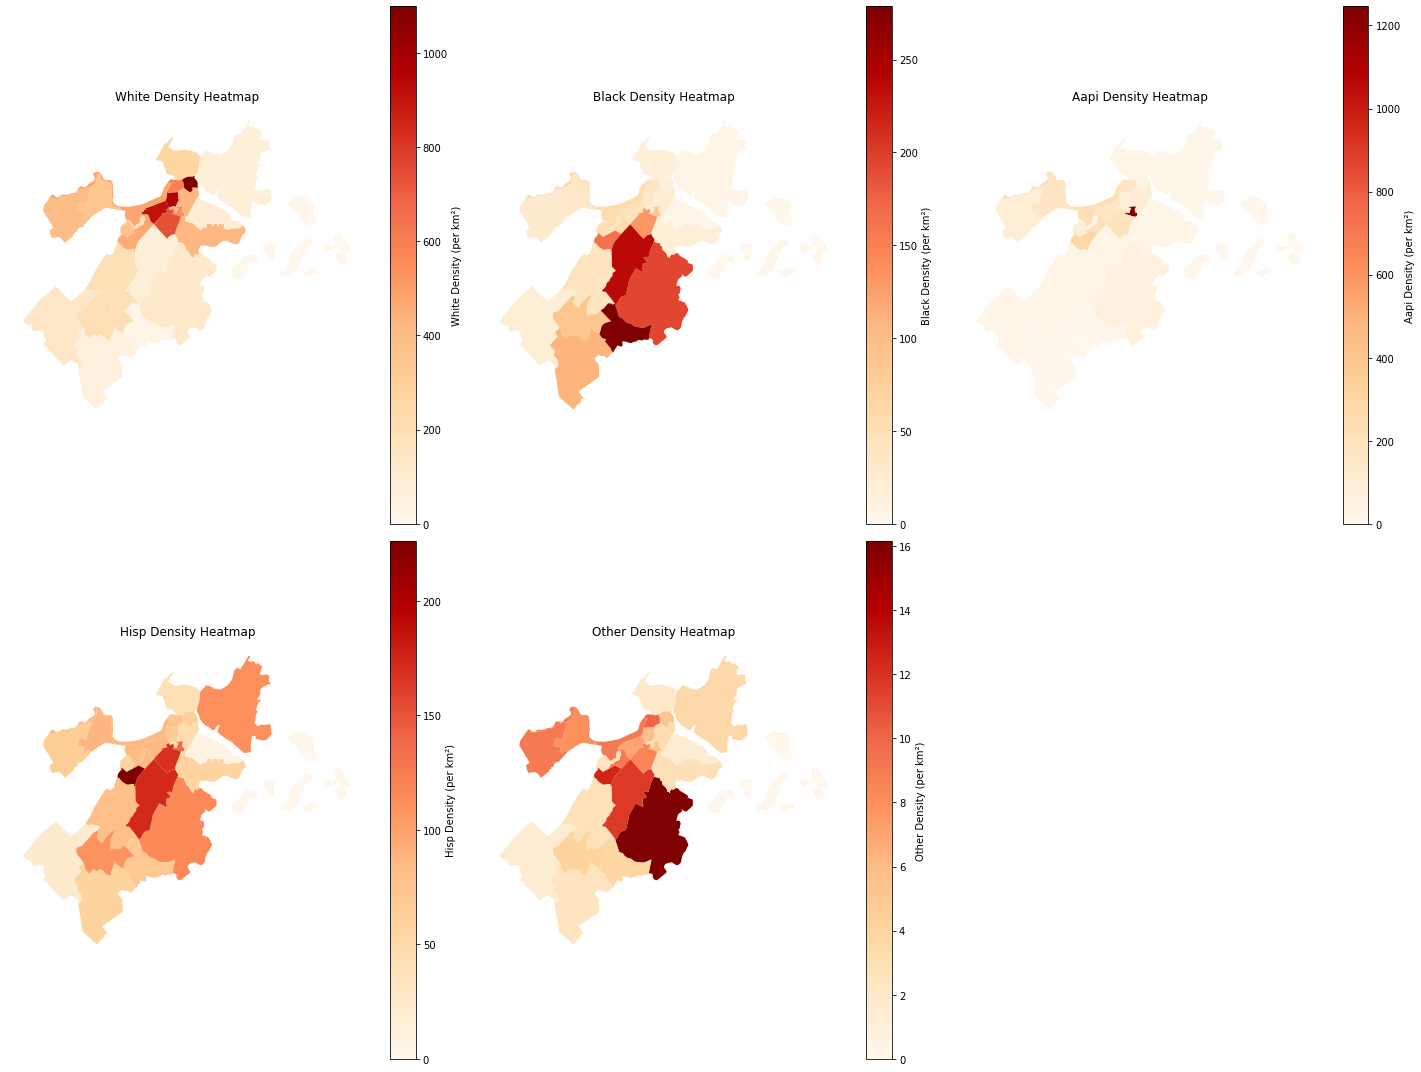

In [7]:
neighborhood_data_gdf = gpd.GeoDataFrame(neighborhood_data, geometry=neighborhoods.geometry)
merged_data_geometry = pd.merge(neighborhoods, neighborhood_data_gdf, on='geometry', how='left')
merged_data_geometry['area_km2'] = merged_data_geometry.geometry.area / 1e6
racial_groups = ['white_all', 'black_all', 'aapi_all', 'hisp_all', 'other_all']

# Recalculate the density of each racial group in each neighborhood
for group in racial_groups:
    merged_data_geometry[f'{group}_density'] = merged_data_geometry[group] / merged_data_geometry['area_km2']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))

for ax, group in zip(axes.flatten(), racial_groups + [""]):
    if group:
        merged_data_geometry.plot(column=f'{group}_density', ax=ax, legend=True, cmap="OrRd", 
                                  legend_kwds={'label': f"{group.split('_')[0].capitalize()} Density (per km²)"})
        ax.set_title(f"{group.split('_')[0].capitalize()} Density Heatmap")
        ax.axis('off')
axes.flatten()[-1].axis('off')

plt.tight_layout()
plt.show()
